We create adversarial examples of twos to be misclassified as sixes from the MNIST dataset by a convolutional neural network. First we simply use the derivative of the error (with the target being 6) with respect to the image pixels (with the image being that of a 2). Next we use the gradient sign method and compute the sign of the derivative. The two approaches produce similar results with respective to artifacts seen in the adversarial image and classification error. We hypothesize that for less artifacts to be present higher resolution, colored images ought to be used for they provide more points of manipulation thereby allowing the artifacts to be spread impercetibly throughout the image.

In [7]:
# Code from "Deep MNIST for Experts" tensorflow tutorial

from __future__ import print_function

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import tensorflow as tf

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Input layer
x  = tf.placeholder(tf.float32, [None, 784], name='x')
y_ = tf.placeholder(tf.float32, [None, 10],  name='y_')
x_image = tf.reshape(x, [-1, 28, 28, 1])

# Convolutional layer 1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Convolutional layer 2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Fully connected layer 1
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob  = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Fully connected layer 2 (Output layer)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')

# Evaluation functions
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Training algorithm
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Training steps
sess = tf.Session()
sess.run(tf.initialize_all_variables())
max_steps = 1000
for step in range(max_steps):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    if (step % 100) == 0:
        print(step, sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
print(max_steps, sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 0.0698
100 0.863
200 0.9099
300 0.9291
400 0.9409
500 0.9445
600 0.955
700 0.9571
800 0.9598
900 0.9629
1000 0.962


The goal is to add noise to images of twos such that they still appear as twos to the human eye but are missclassified as sixes by the model. Therefore we'll need to isolate the twos data. Furthermore we will need these twos to be classified as sixes so that we can harvest the gradients for this missclassification.

In [193]:
# Get twos labels as sixes data
two_images = []
two_labels = []
six_labels = []
six_label = [0.0] * 10
six_label[6] = 1.0
for i in range(len(mnist.train.images)):
    if mnist.train.labels[i][2]==1.0:
        two_images.append(mnist.train.images[i])
        two_labels.append(mnist.train.labels[i])
        six_labels.append(six_label)

Now that we have the desired data we next need a way to get the derivative of the error with respect to the pixels in our image. Tensorflow has a built-in for this.

In [194]:
# Get the gradient of the error with respect to the pixels
grad = tf.gradients(cross_entropy, [x])[0]

Now that we have a bunch of twos labelled as sixes and an easy way to get gradients we're ready to actually compute our gradients. This will give us an image that we can then add to our original images to produce adversarial images.

In [195]:
# Compute delta, the gradient image to be added
import numpy as np
delta = sess.run(grad, feed_dict={x: two_images, y_: six_labels, keep_prob: 1.0})
delta = np.mean(delta, axis=0)
print(delta)

[ 1.18478247e-05 -1.96023302e-05  8.35524770e-06 -4.14494525e-06
 -2.00623181e-05  1.08351533e-05 -4.46160675e-06 -3.41317491e-06
  3.13715173e-05 -2.40116133e-05  1.68744900e-05  3.90736705e-06
  1.39635322e-05  2.43292834e-05 -3.79082007e-06  4.36382288e-06
 -1.80395691e-05 -4.63045154e-07  1.68247479e-05  4.96274561e-06
 -6.42385112e-06  1.12268744e-05 -2.95540176e-05  1.42499448e-05
  1.47808896e-05  4.52385990e-07  2.55029863e-06 -3.68497876e-06
 -1.23171840e-05 -3.92333732e-06 -3.20376421e-05 -3.50429241e-06
 -3.08746166e-05 -2.68998301e-05 -1.79199233e-05  1.64402154e-05
 -3.26587069e-05  3.38586033e-05 -3.34161887e-05  4.46312406e-05
  8.15602561e-06  8.58777184e-06  6.98521671e-06 -6.72475835e-07
 -5.20235471e-06 -2.11445627e-06 -1.32405548e-05  8.85768713e-06
 -3.04131445e-05  3.92428228e-06 -1.03301418e-05 -7.71838586e-07
 -7.95422329e-06 -7.95421329e-06 -3.19123205e-06  3.78725526e-05
 -7.16909426e-06  5.82869598e-06  1.37802426e-05 -3.95305278e-06
 -4.17209194e-05  2.21620

We see that the gradients are tiny. We scale them up by referring to images of the scaled up gradient images added to the original images. Note that adversarial images still look like twos.

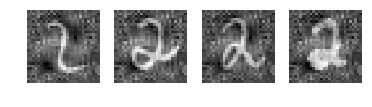

In [196]:
# Plot adversarial images with scaled up delta by 10000
import matplotlib.pyplot as plt
f, xy = plt.subplots(1,4,squeeze=False)
for i in range(4):
    xy[0][i].imshow(np.reshape(two_images[i] - 10000.0 * delta, (28,28)), cmap='gray')
    xy[0][i].axis('off')
plt.show()

Now that we have a reasonably sized delta we can proceed to test our adversarial images and see if they trick the classifier.

In [197]:
# Predictions from classifier on original and adversarial images
pred = sess.run(y, feed_dict={x: two_images, y_: two_labels, keep_prob: 1.0})
print("Number of predicted twos on original images:", [np.argmax(p) for p in pred].count(2))
print("Number of predicted sixes on original images:", [np.argmax(p) for p in pred].count(6))
pred = sess.run(y, feed_dict={x: two_images - 10000.0 * delta, y_: two_labels, keep_prob: 1.0})
print("Number of predicted twos on adversarial images:", [np.argmax(p) for p in pred].count(2))
print("Number of predicted sixes on adversarial images:", [np.argmax(p) for p in pred].count(6))

Number of predicted twos on original images: 5246
Number of predicted sixes on original images: 4
Number of predicted twos on adversarial images: 98
Number of predicted sixes on adversarial images: 3366


We see now that most twos are classified as sixes on the adversarial images. We are asked to produce a collection of original images, their deltas, and their adversarial image counterparts. Since there would be little point in displaying the same delta for every image as used above, we compute a delta for each individual image instead. This in turn requires scaling in the other direction by 0.5. 

Predicted class of two in position 0 : 6
Predicted class of two in position 1 : 6
Predicted class of two in position 2 : 6
Predicted class of two in position 3 : 6
Predicted class of two in position 4 : 2
Predicted class of two in position 5 : 8
Predicted class of two in position 6 : 6
Predicted class of two in position 7 : 8
Predicted class of two in position 8 : 7
Predicted class of two in position 9 : 6


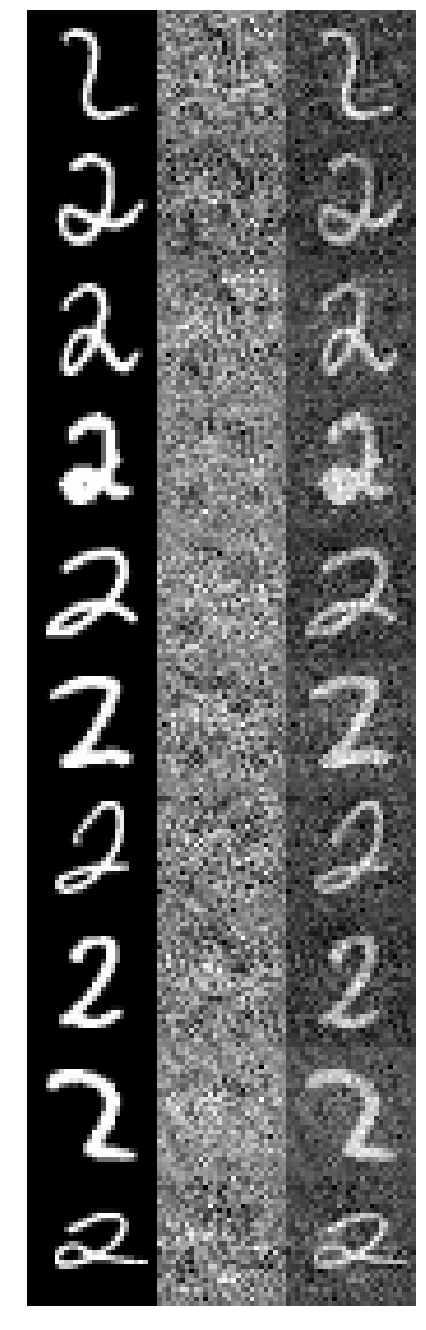

In [198]:
# Plotting code adapted from https://stackoverflow.com/questions/41071947/how-to-remove-the-space-between-subplots-in-matplotlib-pyplot
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 20)) 
gs = gridspec.GridSpec(10, 3, width_ratios=[1, 1, 1], wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 
for i in range(10):
    delta = sess.run(grad, feed_dict={x: [two_images[i]], y_: [six_labels[i]], keep_prob: 1.0})
    delta = np.mean(delta, axis=0) 
    splot = plt.subplot(gs[i,0])
    splot.imshow(np.reshape(two_images[i], (28,28)), cmap='gray')
    splot.axis('off')
    splot = plt.subplot(gs[i,1])
    splot.imshow(np.reshape(-0.5*delta, (28,28)), cmap='gray')
    splot.axis('off')
    splot = plt.subplot(gs[i,2])
    splot.imshow(np.reshape(two_images[i] - 0.5*delta, (28,28)), cmap='gray')
    splot.axis('off')
    pred = sess.run(y, feed_dict={x: [two_images[i] - 0.5 * delta], y_: [two_labels[i]], keep_prob: 1.0})
    print("Predicted class of two in position",i,":", np.argmax(pred))
plt.show()


As we can see most of the twos are classified as sixes when we use the individualized delta as well.

Having heard adversarial examples beforehand we are surprised by the amount of noise required. While the adversarial two images still look like the twos the amount of noise required for misclassification is far from imperceptable. We attribute this to the low dimensionality of the MNIST data set -- both with respect to resolution and color channels. We expect that with a higher resolution, colored image dataset such as ImageNet there would be enough RGB values to adjust so that the overall appearence of the image remained clean.

We compute the fast gradient sign method to see if the results are any better.

In [217]:
# Compute sign of delta and use it for adversarial predictions
delta = sess.run(grad, feed_dict={x: two_images, y_: six_labels, keep_prob: 1.0})
delta = np.mean(delta, axis=0)
delta = np.sign(delta)
delta = delta.astype(float)
pred = sess.run(y, feed_dict={x: two_images - 0.3 * delta, y_: two_labels, keep_prob: 1.0})
print("Number of predicted twos on adversarial images:", [np.argmax(p) for p in pred].count(2))
print("Number of predicted sixes on adversarial images:", [np.argmax(p) for p in pred].count(6))

Number of predicted twos on adversarial images: 179
Number of predicted sixes on adversarial images: 3659


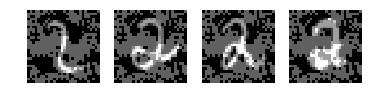

In [218]:
# Plot sign method adversarial twos
f, xy = plt.subplots(1,4,squeeze=False)
for i in range(4):
    xy[0][i].imshow(np.reshape(two_images[i] - 0.3 * delta, (28,28)), cmap='gray')
    xy[0][i].axis('off')
plt.show()

At least on MNIST it appears a matter of subjective opinion whether the gradient sign method performs any better than the method without taking the sign. One nice thing about taking the sign is that it normalizes the gradient image thereby allowing for easy comparison of scaling factors.